#DL-Project
Authors:

Harsha Vishak : 2019A7PS0079G

Aastha Rastogi : 2019A7PS0175G

Athreya Krishnan : 2018B4A70809G

Contributions : Equal

We have chosen the first topic with the task of generating an audio sample based on certain input cues.
For this, we have used a VAE architecture using LSTMs in both the encoder and the decoder networks. 

# Data importing and pre-processing


To run this part, go to Kaggle -> Account -> Create new API Token.

Then upload the downloaded kaggle.json to this colab and run the cells below

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:07<00:00, 148MB/s]
100% 1.21G/1.21G [00:07<00:00, 163MB/s]


In [ ]:
! unzip gtzan-dataset-music-genre-classification.zip

In [ ]:
#importing all the necessary packages
import os
import csv
import numpy as np
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt
import shutil

import torch 
import random
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math

<class 'numpy.ndarray'>


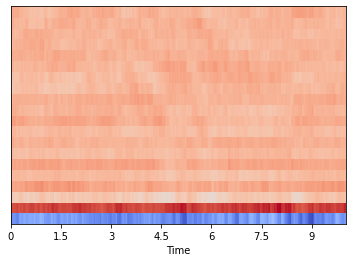

In [ ]:
#MFCC test to generate MFCCs from a random input file.
a, sr = librosa.load('Data/genres_original/classical/classical.00000.wav', duration=10)
mfcc = librosa.feature.mfcc(y=a, sr=sr, n_mfcc=20)
mfcc.shape
print(type(mfcc))
rows, columns = mfcc.shape
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
# librosa.display.specshow(mfcc, sr=sr, y_axis='freq')

In [ ]:
%pwd

'/content'

In [ ]:
%cd Data/genres_original

/content/Data/genres_original


In [ ]:
file = open('GTZAN_2_genres.csv', 'w', newline='')

In [ ]:
genres = 'classical hiphop'.split()
genres

['classical', 'hiphop']

In [ ]:
#we create a CSV file into which we store the MFCC representations
header = "filename"
for i in range(1, 432):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('GTZAN_2_genres.csv', 'w', newline='')

with file:
    writer = csv.writer(file)
    writer.writerow(header)

We convert the wav files into MFCC representations which are stored in a 3D numpy structure. We have a separate array which stores the labels.

In [ ]:
dset = np.array(None,ndmin = 3)
labels = np.array(None,ndmin = 1)
count  = 1
for g in genres:
    for filename in os.listdir(f'./{g}'):
      if(filename == 'hiphop.00032.wav'):
        continue
      # print(filename)
      if(filename == '.ipynb_checkpoints'):
        continue
      audioname = f'./{g}/{filename}'
      for i in range(3):
        a, sr = librosa.load(audioname, offset=10*i, duration=10)
        mfcc = librosa.feature.mfcc(y=a, sr=sr, n_mfcc=20)
        mfcc = np.transpose(mfcc)
        rows, columns = mfcc.shape
        
        if(count==1):
          dset = mfcc[np.newaxis,:,:]
          print(dset.shape)
          count = count+1
          labels = np.atleast_1d(g)
        else:
          dset = np.vstack((dset,mfcc[None]))
          labels = np.append(labels,g)

(1, 431, 20)


In [ ]:
#checking the shape of the matrices.
print(dset.shape)
print(labels.shape)

(597, 431, 20)
(597,)


In [ ]:
#a function to perform onehot encoding on a numpy array
def one_hot(array):
    unique, inverse = np.unique(array, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot

In [ ]:
#splitting the data into training and test and one hot encoding the output features.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()

Y = one_hot(labels)
#Y = np.transpose(Y)
print(dset.shape)
print(Y.shape)
X_train, X_test, y_train, y_test = train_test_split(dset, Y, test_size=0.15, random_state=42)

(597, 431, 20)
(597, 2)


In [ ]:
#converting the numpy matrices into tensors
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

#creating dataloaders to group the data into appropriate batches
X_train = torch.utils.data.DataLoader(dataset = X_train,batch_size = 10)
X_test = torch.utils.data.DataLoader(dataset = X_test,batch_size = 10)
y_train = torch.utils.data.DataLoader(dataset = y_train,batch_size = 10)
y_test = torch.utils.data.DataLoader(dataset = y_test,batch_size = 10)


# The model

We first took the input wav file and converted it into an MFCC form. 
The MFCC representation is fed into an encoder network which is of the form of an LSTM connected to a dense layer. This network provides us with two vectors which we treat as the mean and standard deviation of a normal distribution. We sample a value from this distribution which is the input for the decoder network. 

The decoder follows a similar architecture, we first have a fully connected layer which takes an input which is of the size of the latent dimensions. The output from the fully connected layer is then fed as an input to an LSTM, the output sequence of which is treated to be the MFCC representation of an audio sample.

We have chosen an LSTM based approach due to 


*   We needed a model with an ability to capture sequential data
*   Within sequential models it is more suited for longer input sequences. In our case the MFCC for a ten second sample is of length 431.



In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims,input_size,hidden_size,n_layers):  
        super(VariationalEncoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.linear2 = nn.Linear(hidden_size, latent_dims)
        self.linear3 = nn.Linear(hidden_size, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(type(x))
        x,tempthingy = self.lstm(x)
        #print("the size before mu-")
        #print(x.shape)
        x = x[:,430,:]
        #print(type(x))
        #print("the size after slicing is")
        #print(x.shape)
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims,sequence_length):
        super().__init__()
        self.sequence_length = sequence_length
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, sequence_length),
            nn.ReLU(True)
        )

        self.lstm = nn.LSTM(1, 20, 1, batch_first=True)

        
    def forward(self, x):
        #print(x.shape)
        x = self.decoder_lin(x)
        #print(x.shape)
        x = torch.reshape(x,(10,self.sequence_length,1))
        x,thingy = self.lstm(x)
        #print("encoder output type")
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims,input_size,hidden_size,n_layers,sequence_length):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims,input_size,hidden_size,n_layers)
        self.decoder = Decoder(latent_dims,sequence_length)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        #print("output of encoder -  ")
        #print(z.shape)
        return self.decoder(z)

In [ ]:
torch.manual_seed(0)
d = 2

vae = VariationalAutoencoder(2,20,10,2,431)
lr = 1e-3 
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (lstm): LSTM(20, 10, num_layers=2, batch_first=True)
    (linear2): Linear(in_features=10, out_features=2, bias=True)
    (linear3): Linear(in_features=10, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=431, bias=True)
      (3): ReLU(inplace=True)
    )
    (lstm): LSTM(1, 20, batch_first=True)
  )
)

# Training

In [ ]:
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    #print(dataloader)
    count = 0
    for x in dataloader: 
        # Move tensor to the proper device
        m,n,l = x.shape
        if(m==7):
          continue
        x = x.to(device)
       # print(x.shape)
        x_hat = vae(x)
        # Evaluate loss
        #print(type(x_hat))
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
#calling the training function
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
for i in range(500):
  t_loss = train_epoch(vae,device,X_train,optim)
  print('\t partial train loss (single epoch): %f' % (t_loss))

	 partial train loss (single epoch): 37574819.061144
	 partial train loss (single epoch): 37375298.177515
	 partial train loss (single epoch): 37329110.690335
	 partial train loss (single epoch): 37322266.193294
	 partial train loss (single epoch): 37319343.526627
	 partial train loss (single epoch): 37316237.412229
	 partial train loss (single epoch): 37314377.814596
	 partial train loss (single epoch): 37313642.382643
	 partial train loss (single epoch): 37313551.936884
	 partial train loss (single epoch): 37313402.761341
	 partial train loss (single epoch): 37313239.731755
	 partial train loss (single epoch): 37313252.165680
	 partial train loss (single epoch): 37313182.769231
	 partial train loss (single epoch): 37313103.589744
	 partial train loss (single epoch): 37313076.765286
	 partial train loss (single epoch): 37313108.670611
	 partial train loss (single epoch): 37313095.384615
	 partial train loss (single epoch): 37313074.019724
	 partial train loss (single epoch): 37313052.

# Testing

In [ ]:
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
test_epoch(vae,device,X_test)

38935839.28888889

We have used ten copies of the input since the batch size of 10 has been hardcoded in some parts of the model

In [ ]:
input  = [[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0]]
inp = np.array(input)
inp = torch.from_numpy(inp.astype(np.float32))
inp  = inp.to(device)
#we now pass it to the decoder
output = vae.decoder(inp)
playable = output[0].cpu().detach().numpy()
playable = np.transpose(playable)
#print(output[0].shape)
final = librosa.feature.inverse.mfcc_to_audio(playable)


Below is the final output file.
Unfortunately in spite of a seemingly promising architecture it is unable to generate plausible sounds. 

In [ ]:
import IPython.display as ipd
sr = 22050
ipd.Audio(final, rate=sr) # load a NumPy array